In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

In [5]:
encoder = Inf_network(kwargs=args).to(args.device)
target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
for p in transitions.parameters():
    p.requires_grad_(False)

params = [encoder.parameters(), target.parameters(), transitions.parameters(), reverse_params]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [6]:
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/500 [00:00<?, ?it/s]

On batch number 1/100 and on k = 1 we have for  0: 0.5040000239387155 and for +1: 0.49600002355873585
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 2 we have for  0: 0.49000002327375114 and for +1: 0.5100000242237002
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 3 we have for  0: 0.49600002355873585 and for +1: 0.5040000239387155
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 4 we have for  0: 0.48800002317875624 and for +1: 0.5120000243186951
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 5 we have for  0: 0.472000022418797 and for +1: 0.5280000250786543
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 6 we have for  0: 0.48600002308376133 and for +1: 0.51400002441369
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 7 we have for  0: 0.512000024

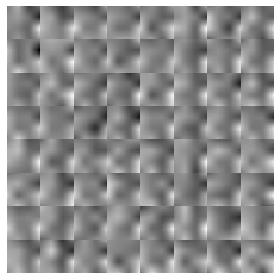

  0%|          | 1/500 [01:23<11:37:51, 83.91s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.5500000261235982 and for +1: 0.4500000213738531
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 2 we have for  0: 0.48200002289377153 and for +1: 0.5180000246036798
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 3 we have for  0: 0.49600002355873585 and for +1: 0.5040000239387155
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 4 we have for  0: 0.5120000243186951 and for +1: 0.48800002317875624
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 5 we have for  0: 0.5000000237487257 and for +1: 0.5000000237487257
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 6 we have for  0: 0.49600002355873585 and for +1: 0.5040000239387155
Stepsize 0.009999999360491285
Autoregression coeff 0.5
On batch number 1/100 and on k = 7 we have for  0: 0.5020000

KeyboardInterrupt: 

In [8]:
print_info_ = 1

torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)


def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new, mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo
  
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches

        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        p_old = args.std_normal.sample(mu.shape)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions

            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        dataset.train.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            # Accumulate alphas
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

        elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                            sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
    #     pdb.set_trace()
        (-grad_elbo).backward()
        if args.clip_norm:
            torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
        optimizer.step()
        optimizer.zero_grad()
        # Bias squared
    if ep % print_info_ == 0:
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print('a')

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)